In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

### PARTIE 1 : Exploration de la base de données

In [128]:
df = pd.read_csv('csv_files/regularite-mensuelle-tgv-aqst.csv',sep=';')
missing_data = df.isnull().sum()
print('Donées manquantes :\n', missing_data[missing_data>0], '\n')
print('Type des données :', '\n', df.dtypes)

Donées manquantes :
 commentaire_annulation         8154
commentaire_retards_depart     8154
commentaires_retard_arrivee    7456
dtype: int64 

Type des données : 
 date                                     object
service                                  object
gare_depart                              object
gare_arrivee                             object
duree_moyenne                             int64
nb_train_prevu                            int64
nb_annulation                             int64
commentaire_annulation                  float64
nb_train_depart_retard                    int64
retard_moyen_depart                     float64
retard_moyen_tous_trains_depart         float64
commentaire_retards_depart              float64
nb_train_retard_arrivee                   int64
retard_moyen_arrivee                    float64
retard_moyen_tous_trains_arrivee        float64
commentaires_retard_arrivee              object
nb_train_retard_sup_15                    int64
retard_moyen_trains

In [129]:
def information_dataset():
    print('Information : ', '\n', df.info())
    print('Description statistique de chaque colonne : ', '\n', df.describe())
#information_dataset

### PARTIE 2 : Traitement de la base de données

#### 1 : Gestion des commentaires

On observe que les seules valeurs manquantes sont pour les features commentaires : commentaire_annulation, commentaire_retards_depart
et commentaire_retard_arrivee.
Pour une première approche simplificatrice du dataset, on prend la décision de supprimier les features commentaires.

In [130]:
df_clean = (
    df.copy()
        .drop(
            ["commentaire_annulation", "commentaire_retards_depart", "commentaires_retard_arrivee"],
            axis=1,
        )
)

df_clean.columns

Index(['date', 'service', 'gare_depart', 'gare_arrivee', 'duree_moyenne',
       'nb_train_prevu', 'nb_annulation', 'nb_train_depart_retard',
       'retard_moyen_depart', 'retard_moyen_tous_trains_depart',
       'nb_train_retard_arrivee', 'retard_moyen_arrivee',
       'retard_moyen_tous_trains_arrivee', 'nb_train_retard_sup_15',
       'retard_moyen_trains_retard_sup15', 'nb_train_retard_sup_30',
       'nb_train_retard_sup_60', 'prct_cause_externe', 'prct_cause_infra',
       'prct_cause_gestion_trafic', 'prct_cause_materiel_roulant',
       'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs'],
      dtype='object')

#### 2 : Gestion de la colonne service

In [131]:
df_clean["service"].unique()

array(['National', 'International'], dtype=object)

On observe que la colonne ne possède que deux valeurs categorielles, nous allons faire un "one-hot" encoding et creer une feature booléenne "national_service"

In [132]:
df_clean["national_service"] = np.where(df_clean["service"]=="National", 1,0)
df_clean.drop("service", axis=1, inplace=True)

#### 3 : Gestion de la date
Nous allons créer deux colonnes, une pour le mois et l'autre pour l'année.


In [133]:
df_clean[['annee', 'mois']] = df_clean['date'].str.split('-', expand=True)
df_clean.drop("date", axis=1, inplace=True)

#### 4 : Gestion des villes
La dernière étape du preprocessing est celle du traitement des colonnes gare_depart et gare_arrivee. Pour garde l'information gare de départ ou d'arrivée, on crée une colonne par ville de départ, avec le préfixe DEPART, et de même avec les villes d'arrivée, avec le préfixe ARRIVEE. On décide ainsi de garder la visibilité sur les caractéristiques de départ et d'arrivée des gares, car en effet la gare du départ ou d'arrivée peut avoir un impact sur le retard indépendemment du trajet. Pour une meilleure utilisation de la base de données pour la suite des traitements, en particulier l'ajout de nouveaux features, on garde cette étape comme dernière étape du traitement complet de la base de données.

### PARTIE 3 : Ajout de nouveaux features intéressants

Dans notre objectif de prédire les retards des trains TGV à l'arrivée, certaines features nous semblent intéressants à ajouter au dataset : 
- Le **nombre de voies par gare**. On pourra ainsi chercher une relation entre les retards d'une gare et le nombre de voies qu'elle possède.
- Les mois possédant des semaines de **vacances scolaires**. On cherche ici une relation possible entre les mois à plus forts retards et l'affluence en gare / fréquentation des transports ferroviaires sur lces periodes de vacances.
- La **distance entre deux gares**. Y a-t'il plus de retards sur les longs trajets ? Existe-t'il une relation entre distance entre deux gares et retards sur cette ligne ?
- Les **coordonnées GPS des gares**. En remplaçant les noms des gares par leurs coordonnées GPS, on pourrait plus facilement accéder à la distance entre deux gares. 

 #### 1 : Ajouter le nombre de voies par gare

On commence par créer un fichier *nbdevoies.csv* contenant le nombre de voies pour chaque gare du dataset. 
Tout d'abord, on récupère la liste des gares présentes dans le dataset. Puis, pour chacune d'entre elles, on recherche le nombre de voies qu'elle possède. Les données sont obtenues par recherches personnelles.
Dans les gares, les passagers sont sur les quais et les trains sur les voies. En comptant le nombre de voies, on peut avoir une idée du nombre maximal de trains qu'il est possible d'avoir en gare en même temps.

In [134]:
nb_voies = pd.read_csv('csv_files/nbdevoies.csv',sep=',')
def informations_nb_voies(): 
    print('Donées manquantes :', '\n', nb_voies.isnull().sum(), '\n') # Vérifier que le dataset est bien complet 
    print('Type des données :', '\n', nb_voies.dtypes)
    nb_voies

Après l'importation de ce fichier *nb_voies*, on intègre les valeurs au dataset *data_clean* pour chaque gare correspondante. On appelera *nb_voies_depart* et *nb_voies_arrivee* resepctivement les nombres de voies dans les gares de départ et d'arrivée d'un trajet. 

In [135]:
# Fusionnez les deux dataframe df_clean et nb_voies selon les noms des gares de départ et d'arrivée
gares_voies_dict = dict(zip(nb_voies['gare'], nb_voies[' nb_voies']))

df_clean['nb_de_voies_depart'] = df_clean['gare_depart'].map(gares_voies_dict)
df_clean['nb_de_voies_arrivee'] = df_clean['gare_arrivee'].map(gares_voies_dict)


#### 2 : Ajouter les vacances scolaires

On souhaite désormais marquer chaque mois contenant des semaines de vacances scolaires depuis le mois de janvier 2018 jusqu'au mois de juin 2023. On repère par 1 un mois contenant des vacances, et par 0 un mois sans.

In [136]:
vac = pd.read_csv('csv_files/vacances_scolaires.csv',sep=';')

def informations_vac_scolaire():
    print('Donées manquantes :', '\n', vac.isnull().sum(), '\n')
    print('Type des données :', '\n', vac.dtypes)
    vac

In [137]:
df_clean['annee'] = df_clean['annee'].astype(int)
df_clean['mois'] = df_clean['mois'].astype(int)
df_clean = df_clean.merge(vac, on=['annee', 'mois'], how='left')

#### 3 : Ajouter les coordonnées GPS des gares

Dans le but de simplifier la transformation en données numériques des noms des gares, on décide de travailler avec leurs coordonnées GPS. 

In [138]:
coord = pd.read_csv('csv_files/coord_gps_gares_mis_a_jour.csv')
def informations_coord_gps():
    print('Donées manquantes :', '\n', coord.isnull().sum(), '\n')
    print('Type des données :', '\n', coord.dtypes)
    coord

In [139]:
df_clean = df_clean.merge(coord, left_on='gare_depart', right_on='Gare', how='left')
df_clean.rename(columns={'Latitude': 'Latitude_depart'}, inplace=True)
df_clean.rename(columns={'Longitude': 'Longitude_depart'}, inplace=True)
df_clean = df_clean.merge(coord, left_on='gare_arrivee', right_on='Gare', how='left')
df_clean.rename(columns={'Latitude': 'Latitude_arrivee'}, inplace=True)
df_clean.rename(columns={'Longitude': 'Longitude_arrivee'}, inplace=True)
df_clean.drop(['Gare_x', 'Gare_y'], axis=1, inplace=True)


#### 4 : Ajouter la distance d'un trajet
On décide d'ajouter un feature, celui de la distance entre deux gares, soit la distance à vol d'oiseau d'un trajet. 

In [140]:
distance = pd.read_csv('csv_files/distance_gares_mis_a_jour.csv')
if 'Gare 1' in distance.columns and 'Gare 2' in distance.columns:
    distance = distance.rename(columns={'Gare 1': 'gare_depart', 'Gare 2': 'gare_arrivee'}) 
merged_data = df_clean.merge(distance, left_on=['gare_depart', 'gare_arrivee'], right_on=['gare_depart', 'gare_arrivee'], how='left')
df_distance_inverse = distance.rename(columns={'gare_depart': 'gare_arrivee', 'gare_arrivee': 'gare_depart'})
merged_data_inverse = df_clean.merge(df_distance_inverse, left_on=['gare_depart', 'gare_arrivee'], right_on=['gare_depart', 'gare_arrivee'], how='left')
merged_data['Distance (km)'] = merged_data['Distance (km)'].combine_first(merged_data_inverse['Distance (km)'])

In [141]:
merged_data[:5]

,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,nb_train_retard_arrivee,retard_moyen_arrivee,...,annee,mois,nb_de_voies_depart,nb_de_voies_arrivee,vacances,Latitude_depart,Longitude_depart,Latitude_arrivee,Longitude_arrivee,Distance (km)
0,PARIS LYON,AIX EN PROVENCE TGV,186,424,0,49,10.284354,0.906840,47,36.946454,...,2018,1,32,4,0,48.844806,2.373479,43.46033,5.318789,640.140338
1,PARIS LYON,AIX EN PROVENCE TGV,186,398,3,47,14.412766,1.397975,48,31.237153,...,2018,2,32,4,1,48.844806,2.373479,43.46033,5.318789,640.140338
2,PARIS LYON,AIX EN PROVENCE TGV,186,430,9,47,13.223404,1.177791,37,36.111712,...,2018,3,32,4,0,48.844806,2.373479,43.46033,5.318789,640.140338
3,PARIS LYON,AIX EN PROVENCE TGV,187,461,134,41,18.110163,1.917074,37,36.597748,...,2018,4,32,4,1,48.844806,2.373479,43.46033,5.318789,640.140338
4,PARIS LYON,AIX EN PROVENCE TGV,188,457,76,42,25.143651,2.662992,65,33.587949,...,2018,5,32,4,0,48.844806,2.373479,43.46033,5.318789,640.140338


### PARITE 4 : Etudier la corrélation entre les features du dataset
Pour avoir une première idée des corrélations existantes entre les features, on affiche la matrice de corrélation du dataset.On utilise Seaborn pour créer un graphique et afficher la matrice de corrélation.

In [142]:
df_corr = merged_data.copy()
df_corr.drop('gare_depart', axis=1, inplace=True)
df_corr.drop('gare_arrivee', axis=1, inplace=True)
df_corr[:7]

,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,nb_train_retard_arrivee,retard_moyen_arrivee,retard_moyen_tous_trains_arrivee,nb_train_retard_sup_15,...,annee,mois,nb_de_voies_depart,nb_de_voies_arrivee,vacances,Latitude_depart,Longitude_depart,Latitude_arrivee,Longitude_arrivee,Distance (km)
0,186,424,0,49,10.284354,0.906840,47,36.946454,4.340881,44,...,2018,1,32,4,0,48.844806,2.373479,43.46033,5.318789,640.140338
1,186,398,3,47,14.412766,1.397975,48,31.237153,5.201392,40,...,2018,2,32,4,1,48.844806,2.373479,43.46033,5.318789,640.140338
2,186,430,9,47,13.223404,1.177791,37,36.111712,4.212470,36,...,2018,3,32,4,0,48.844806,2.373479,43.46033,5.318789,640.140338
3,187,461,134,41,18.110163,1.917074,37,36.597748,4.954689,35,...,2018,4,32,4,1,48.844806,2.373479,43.46033,5.318789,640.140338
4,188,457,76,42,25.143651,2.662992,65,33.587949,6.601706,50,...,2018,5,32,4,0,48.844806,2.373479,43.46033,5.318789,640.140338
5,187,450,31,58,29.341954,4.020923,73,34.161872,5.384726,47,...,2018,6,32,4,0,48.844806,2.373479,43.46033,5.318789,640.140338
6,183,465,7,131,18.083461,4.957969,112,38.861310,11.603930,105,...,2018,7,32,4,1,48.844806,2.373479,43.46033,5.318789,640.140338


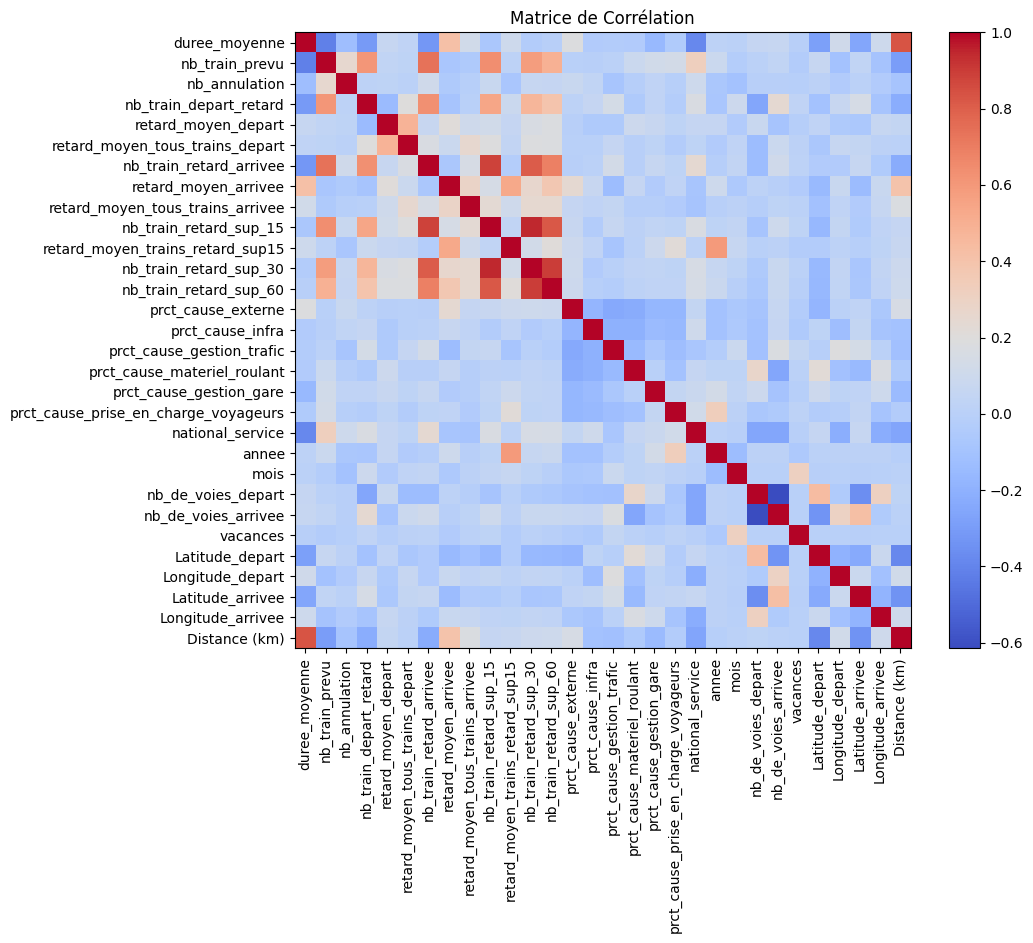

In [143]:
correlation_matrix = df_corr.corr()
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Matrice de Corrélation')
plt.show()

In [144]:

def values_corr(numberOfValues,matrix_corr):
    # Tri de la matrice de corrélation en un DataFrame
    correlation_df = pd.DataFrame(matrix_corr.unstack().sort_values(ascending=False), columns=['correlation'])

    # Supprimez les corrélations de 1.0
    correlation_df = correlation_df[correlation_df['correlation'] < 1.0]

    # Afficher les corrélations les plus fortes
    top_corr = correlation_df.head(numberOfValues)
    return(top_corr)

print(values_corr(10,correlation_matrix))

                                                 correlation
nb_train_retard_sup_30  nb_train_retard_sup_15      0.945495
nb_train_retard_sup_15  nb_train_retard_sup_30      0.945495
nb_train_retard_sup_60  nb_train_retard_sup_30      0.896712
nb_train_retard_sup_30  nb_train_retard_sup_60      0.896712
nb_train_retard_arrivee nb_train_retard_sup_15      0.886350
nb_train_retard_sup_15  nb_train_retard_arrivee     0.886350
Distance (km)           duree_moyenne               0.831668
duree_moyenne           Distance (km)               0.831668
nb_train_retard_sup_60  nb_train_retard_sup_15      0.819064
nb_train_retard_sup_15  nb_train_retard_sup_60      0.819064


On remarque que les corrélations sont surtout sur les retards de trains.  
Nous savions avant la réalisation de la matrice que cela allait arriver.  
Voyons ce qu'il se passe lorsque cette fois-ci nous enlevons ces colonnes.

In [150]:
dropColumns = ['retard_moyen_depart','retard_moyen_tous_trains_depart',
                'nb_train_retard_arrivee','retard_moyen_arrivee','retard_moyen_tous_trains_arrivee',
               'nb_train_retard_sup_15','retard_moyen_trains_retard_sup15','nb_train_retard_sup_30',
               'nb_train_retard_sup_60']
df_corr_drop_late_columns = df_corr.drop(columns=dropColumns)
correlation_matrix_drop_columns = df_corr_drop_late_columns.corr()
print(values_corr(10,correlation_matrix_drop_columns))

                                                                           correlation
Distance (km)                        duree_moyenne                            0.831668
duree_moyenne                        Distance (km)                            0.831668
nb_train_prevu                       nb_train_depart_retard                   0.602848
nb_train_depart_retard               nb_train_prevu                           0.602848
Latitude_depart                      nb_de_voies_depart                       0.436109
nb_de_voies_depart                   Latitude_depart                          0.436109
nb_de_voies_arrivee                  Latitude_arrivee                         0.421088
Latitude_arrivee                     nb_de_voies_arrivee                      0.421088
prct_cause_prise_en_charge_voyageurs annee                                    0.327369
annee                                prct_cause_prise_en_charge_voyageurs     0.327369


### PARTIE 5 : Encoding des gares de départ et d'arrivée

In [146]:
depart = pd.get_dummies(merged_data['gare_depart'],prefix='DEPART')
merged_data= pd.concat([merged_data,depart], axis=1) 
arrivee = pd.get_dummies(merged_data['gare_arrivee'],prefix='ARRIVEE')
merged_data= pd.concat([merged_data,arrivee], axis=1) 

Après avoir ajouté tous les features souhaités, on supprime les colonnes gare_depart et gare_arrivee pour ne garder que des données numériques dans le dataset final.

In [147]:
merged_data.drop('gare_depart', axis=1, inplace=True)
merged_data.drop('gare_arrivee', axis=1, inplace=True)

In [148]:
merged_data[:5]

,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,nb_train_retard_arrivee,retard_moyen_arrivee,retard_moyen_tous_trains_arrivee,nb_train_retard_sup_15,...,ARRIVEE_ST PIERRE DES CORPS,ARRIVEE_STRASBOURG,ARRIVEE_STUTTGART,ARRIVEE_TOULON,ARRIVEE_TOULOUSE MATABIAU,ARRIVEE_TOURCOING,ARRIVEE_TOURS,ARRIVEE_VALENCE ALIXAN TGV,ARRIVEE_VANNES,ARRIVEE_ZURICH
0,186,424,0,49,10.284354,0.906840,47,36.946454,4.340881,44,...,0,0,0,0,0,0,0,0,0,0
1,186,398,3,47,14.412766,1.397975,48,31.237153,5.201392,40,...,0,0,0,0,0,0,0,0,0,0
2,186,430,9,47,13.223404,1.177791,37,36.111712,4.212470,36,...,0,0,0,0,0,0,0,0,0,0
3,187,461,134,41,18.110163,1.917074,37,36.597748,4.954689,35,...,0,0,0,0,0,0,0,0,0,0
4,188,457,76,42,25.143651,2.662992,65,33.587949,6.601706,50,...,0,0,0,0,0,0,0,0,0,0


### PARTIE 6 : Exportation de la base de donnée traitée
Enfin, on exporte le dataframe en fichier csv pour la suite des entrainements et des tests de plusieurs modèles.

In [149]:

if os.path.exists('csv_files/train_bdd_clean.csv'):
    pass
else : 
    merged_data.to_csv('csv_files/train_bdd_clean.csv', index=False)